# Endometrial cancer segmentation - training
Last checked and validated with `fastMONAI` version `0.3.4`

In [ ]:
# Import the necessary modules
from fastMONAI.vision_all import *
from monai.networks.nets import UNet
from monai.losses import DiceCELoss

In [ ]:
# Create a custom loss function using Tversky Focal Loss
loss_func = CustomLoss(loss_func=DiceCELoss(to_onehot_y=True, include_background=True, softmax=True))

# Create a UNet model with the specified parameters
model = UNet(spatial_dims=3, in_channels=3, out_channels=2, channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2), num_res_units=2).model

## Train your own model 

In [ ]:
NB_DIR = Path.cwd()
DATA_DIR = NB_DIR/'../../data'/'EC'/'dev_julie'

In [ ]:
# Read the data from the specified CSV file
df = pd.read_csv(DATA_DIR/'nifti_data.csv')
df.head(1)

,vibe_path,t2_path,adc_path,mask_path,subject_id,tumor_vol,orientations,is_valid,rater
0,/home/sathiesh/lib_dev/fastMONAI/research_ec/../data/EC/dev_julie/nii_img/img_348.nii.gz,/home/sathiesh/lib_dev/fastMONAI/research_ec/../data/EC/dev_julie/t2/T2-2-vibe2min-header-348.nii.gz,/home/sathiesh/lib_dev/fastMONAI/research_ec/../data/EC/dev_julie/adc/ADC-2-vibe2min-header-348.nii.gz,/home/sathiesh/lib_dev/fastMONAI/research_ec/../data/EC/dev_julie/org_mask/348segmentedJulie.nii.gz,348,34.4,LPS,False,Julie


In [ ]:
#Only using the validation labels from one rater. 
df = df.drop_duplicates(subset='subject_id', keep='first').reset_index(drop=True)

In [ ]:
cat = [round(size,-1)for size in df.tumor_vol.tolist()]
df['cat'] = cat

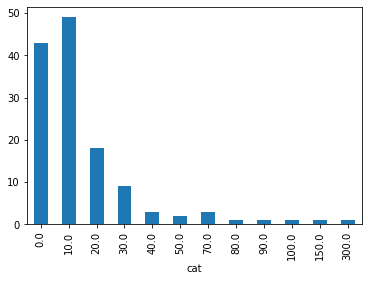

In [ ]:
df.cat.value_counts().sort_index().plot(kind = 'bar')
plt.show()

In [ ]:
df = df.loc[df.subject_id != 336]
df = df.loc[df.tumor_vol <= 300].reset_index(drop=True)

### Look at training data

In [ ]:
med_dataset = MedDataset(img_list=df.vibe_path.tolist(), max_workers=12);

The volumes in this dataset have different orientations. Recommended to pass in the argument reorder=True when creating a MedDataset object for this dataset


In [ ]:
data_info_df = med_dataset.summary()

In [ ]:
data_info_df.head()

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
1,192,192,48,1.3021,1.3021,2.0,LPS+,/home/sathiesh/lib_dev/fastMONAI/research_ec/../data/EC/dev_julie/nii_img/img_011.nii.gz,38
0,192,192,48,1.3021,1.3021,2.0,LIP+,/home/sathiesh/lib_dev/fastMONAI/research_ec/../data/EC/dev_julie/nii_img/img_022.nii.gz,25
4,232,256,88,0.9766,0.9766,1.2,LPS+,/home/sathiesh/lib_dev/fastMONAI/research_ec/../data/EC/dev_julie/nii_img/img_367.nii.gz,22
3,232,256,88,0.9766,0.9766,1.2,LIP+,/home/sathiesh/lib_dev/fastMONAI/research_ec/../data/EC/dev_julie/nii_img/img_372.nii.gz,21
9,256,232,88,0.9766,0.9766,1.2,LIP+,/home/sathiesh/lib_dev/fastMONAI/research_ec/../data/EC/dev_julie/nii_img/img_352.nii.gz,9


In [ ]:
# Get the suggested resampling and reordering values from the dataset
resample, reorder = med_dataset.suggestion()
resample, reorder

([1.3021, 1.3021, 1.2], False)

In [ ]:
resample = [1, 1, 1]

In [ ]:
# Get the largest image size from the dataset, using the specified resampling values
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size

[330.0, 330.0, 125.0]

In [ ]:
size = [160, 160, 128]
bs = 8

### Create MedDataBlock and Learner

In [ ]:
# Create a list of transformations to apply to the images, with a probability of 0.5 for each transformation being applied
item_tfms = [ZNormalization(), PadOrCrop(size), RandomAffine(scales=(0.9, 1.2), degrees=20, p=0.5),
             RandomFlip(), RandomGamma(log_gamma=(-0.2, 0.2), p=0.5)]

In [ ]:
# Create a MedDataBlock with the specified blocks, splitter, and item transformations
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), MedMaskBlock), 
                      splitter=ColSplitter('is_valid'),
                      get_x=ColReader(['t2_path', 'vibe_path', 'adc_path']),
                      get_y=ColReader('mask_path'),
                      item_tfms=item_tfms,
                      reorder=reorder,
                      resample=resample) 

In [ ]:
dls = dblock.dataloaders(df, bs=bs)

In [ ]:
# training and validation
len(dls.train_ds.items), len(dls.valid_ds.items)

(99, 31)

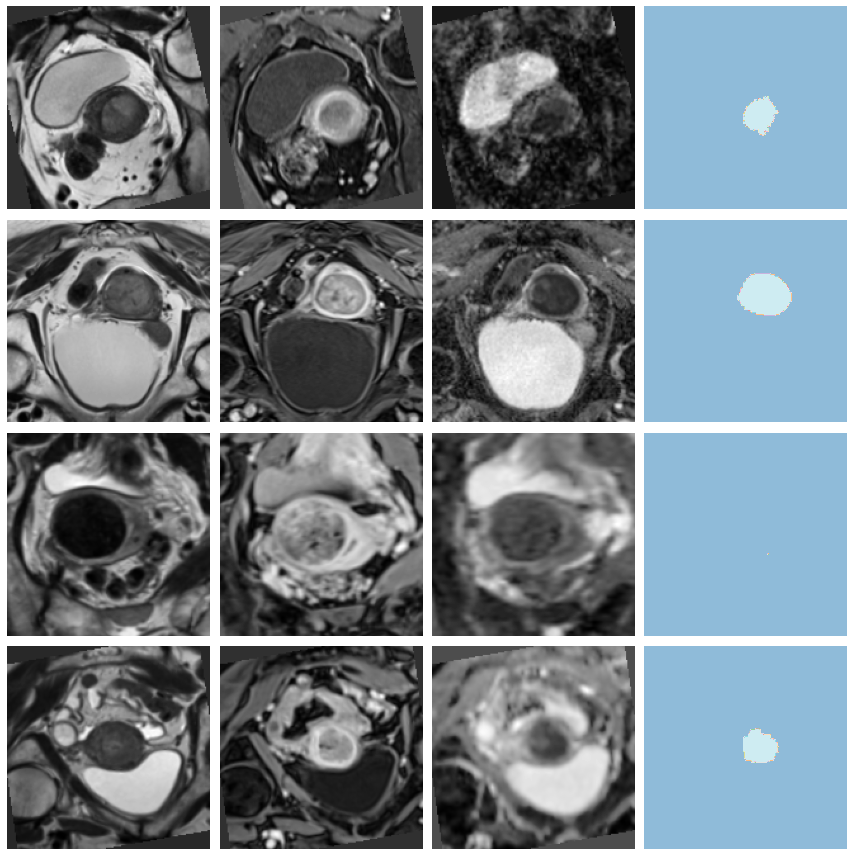

In [ ]:
dls.show_batch(unique=False, max_n=4, anatomical_plane=2) 

In [ ]:
learn = Learner(dls, model, loss_func=loss_func, opt_func= ranger, metrics=multi_dice_score)

SuggestedLRs(valley=0.0030199517495930195)

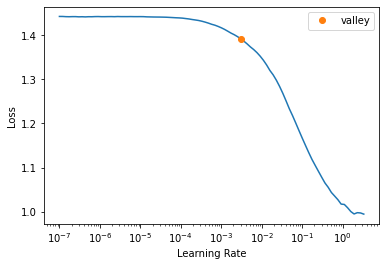

In [ ]:
lr=learn.lr_find()
lr 

In [ ]:
lr = 0.01

In [ ]:
learn.fit_flat_cos(100,lr, cbs=SaveModelCallback(fname='t2-vibe-adc-ec-unet', monitor='multi_dice_score', min_delta=0.005))

Better model found at epoch 91 with multi_dice_score value: 0.7824019193649292.

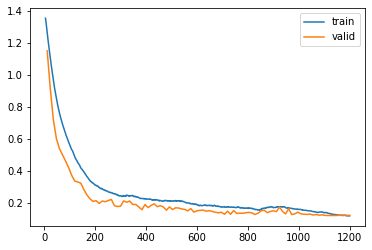

In [ ]:
learn.recorder.plot_loss()

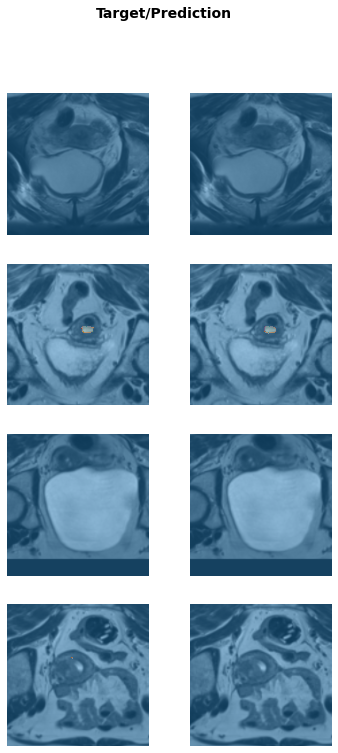

In [ ]:
learn.show_results(max_n=4, anatomical_plane=2)

In [ ]:
store_variables(pkl_fn='models/vars.pkl', size=size, reorder=reorder, resample=resample)

In [ ]:
learn.export(f'models/t2-vibe-adc-learner.pkl')